In [2]:
from partial_ranker import PartialRankerDFG
from partial_ranker import PartialRankerDFGReduced
from partial_ranker import PartialRankerMin

In [123]:
%%writefile ../partial_ranker_wrapper.py
# Partial Ranker
#
# Copyright (C) 2019-2024, Aravind Sankaran
# IRTG-2379: Modern Inverse Problems, RWTH Aachen University, Germany
# HPAC, Umeå University, Sweden
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# Contributors:
# - Aravind Sankaran

from enum import Enum
from typing import List
from .partial_ranker_dfg import PartialRankerDFG
from .partial_ranker_dfg_r import PartialRankerDFGReduced
from .partial_ranker_min import PartialRankerMin

class Method(Enum):
    """An Enum class to specify the method to compute the partial ranks.
    """
    DFG = 1
    DFGReduced = 2
    Min = 3

class PartialRanker:
    """A general class to compute the partial ranks of objects based on the results of pair-wise comparisons.
    
    Input:
        comparer (partial_ranker.QuantileComparer):
            The ``QuantileComparer`` object that contains the results of pair-wise comparisons.
            i.e, ``comparer.compare()`` should have been called.
            
        method (Method):
            The method to compute the partial ranks. The default is `Method.DFGReduced`.
            
            - `Method.DFG`: The methodology implemenmted in ``partial_ranker.PartialRankerDFG`` is used.
            - `Method.DFGReduced`: The methodology implemenmted in ``partial_ranker.PartialRankerDFGReduced`` is used.
            - `Method.Min`: The methodology implemenmted in ``partial_ranker.PartialRankerMin`` is used.
        
    **Attributes and Methods**:
    
    Attributes:
        ranker: The instance of the partial ranking methodology class used to compute the partial ranks.
        
    """
    def __init__(self, comparer, method: Method=Method.DFGReduced):
        self.comparer = comparer
        self.method = method
        self.ranker = None
        
    def compute_ranks(self, method: Method=Method.DFGReduced) -> None:
        """Computes the partial ranks of objects. 
        The attribute `ranker` is set to the instance of the partial ranking methodology class used to compute the partial ranks.

        Args:
            method (Method, optional): The method to compute the partial ranks. Defaults to Method.DFGReduced.
        """
        self.method = method
        
        if self.method == Method.DFG:
            self.ranker = PartialRankerDFG(self.comparer)
            self.ranker.compute_ranks()
        elif self.method == Method.DFGReduced:
            self.ranker = PartialRankerDFGReduced(self.comparer)
            self.ranker.compute_ranks()
        elif self.method == Method.Min:
            self.ranker = PartialRankerMin(self.comparer)
            self.ranker.compute_ranks()
            
    def get_separable_arrangement(self) -> List[str]:
        """
        Returns:
            List[str]: Arrangement of the objects according to ``PartialRankerDFG.get_dfg().get_separable_arrangement()``. 
        """
        if self.method == Method.Min:
            pr = PartialRankerDFG(self.comparer)
            pr.compute_ranks()
            return pr.get_dfg().get_separable_arrangement()
        elif self.method == Method.DFGReduced:
            return self.ranker.graph_H.get_separable_arrangement()
        elif self.method == Method.DFG:
            return self.ranker.get_dfg().get_separable_arrangement()
        else:
            raise ValueError("Method not supported")
    
    def get_ranks(self) -> dict[int,list[str]]:
        """
        Returns:
            dict[int,List[str]]: A dictionary consisting of the list of objects at each rank.
            e.g.; ``{0: ['obj1'], 1: ['obj2', 'obj3'], ...}``.
        """
        return self.ranker.get_ranks()
    
    def get_rank_obj(self,obj) -> int:
        """  
        Args:
            obj (str): Object name.
        
        Returns:
            int: The partial rank of a given object.
        """
        return self.ranker.get_rank_obj(obj)
        
    def get_dfg(self):
        """
        Returns:
            partial_ranker.Graph: A Graph object that represents the rank relation among the objects.
        """
        return self.ranker.get_dfg()

Overwriting ../partial_ranker_wrapper.py


#### Requirements

In [98]:
import numpy as np
from partial_ranker.measurements_simulator import MeasurementsSimulator
from partial_ranker.measurements_visualizer import MeasurementsVisualizer
from partial_ranker import QuantileComparer

1. Prepare measurements

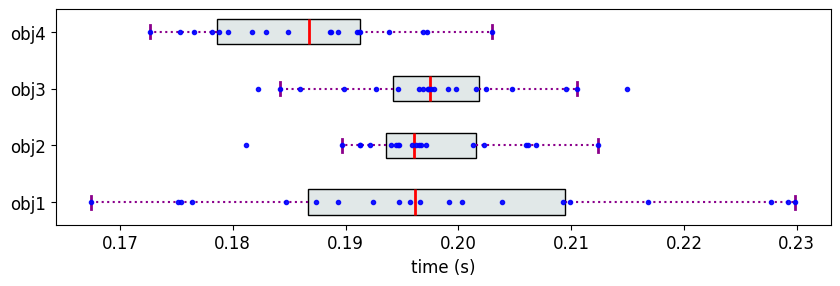

In [99]:
obj_params = {}
obj_params['obj1']  = [0.2,0.02] # [mean, std]
obj_params['obj2']  = [0.2,0.01]
obj_params['obj3']  = [0.2,0.01]
obj_params['obj4']  = [0.19,0.01]
ms = MeasurementsSimulator(obj_params,seed=129)
reps = 20
ms.measure(reps=reps)
measurements = ms.get_measurements()
h0 = list(obj_params.keys())
mv = MeasurementsVisualizer(measurements, h0)
fig = mv.show_measurements_boxplots(scale=0.7)

2. Compare

In [100]:
comparer = QuantileComparer(measurements)
comparer.compute_quantiles(q_max=75, q_min=25,outliers=False)
comparer.compare()
comparer.C

{'obj1': {'obj1': -1, 'obj2': 1, 'obj3': 1, 'obj4': 1},
 'obj2': {'obj1': 1, 'obj2': -1, 'obj3': 1, 'obj4': 2},
 'obj3': {'obj1': 1, 'obj2': 1, 'obj3': -1, 'obj4': 2},
 'obj4': {'obj1': 1, 'obj2': 0, 'obj3': 0, 'obj4': -1}}

#### Usage

1. PartialRankerDFGReduce (Defualt)

In [101]:
pr = PartialRanker(comparer)
pr.compute_ranks()
pr.get_ranks()

{0: ['obj4', 'obj1', 'obj2', 'obj3']}

In [102]:
pr.get_separable_arrangement()

['obj4', 'obj1', 'obj2', 'obj3']

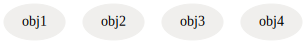

In [103]:
pr.get_dfg().visualize()

2. PartialRankerDFG

In [104]:
pr.compute_ranks(Method.DFG)
pr.get_ranks()

{0: ['obj1', 'obj4'], 1: ['obj2', 'obj3']}

In [105]:
pr.get_separable_arrangement()

['obj4', 'obj1', 'obj2', 'obj3']

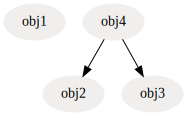

In [106]:
pr.get_dfg().visualize()

3. PartialRankerMin

In [107]:
pr.compute_ranks(Method.Min)
pr.get_ranks()

{0: {'obj1', 'obj2', 'obj3', 'obj4'}}

In [108]:
pr.get_separable_arrangement()

['obj4', 'obj1', 'obj2', 'obj3']

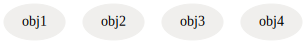

In [109]:
pr.get_dfg().visualize()

#### Scaling Experiment

In [110]:
def create_measurements(n_objs, n_reps, seed=129):
    obj_params = {}
    for i in range(n_objs):
        obj_params[f'obj{i}'] = [np.random.uniform(0,1), np.random.uniform(0,0.1)]
    ms = MeasurementsSimulator(obj_params,seed=seed)
    ms.measure(reps=n_reps)
    return ms.get_measurements()

In [111]:
measurements = create_measurements(50, 5)

In [112]:
cm = QuantileComparer(measurements)
cm.compute_quantiles(75, 25,False)
cm.compare()

In [113]:
pr_ = PartialRanker(cm)

In [114]:
pr_.compute_ranks(Method.DFG)

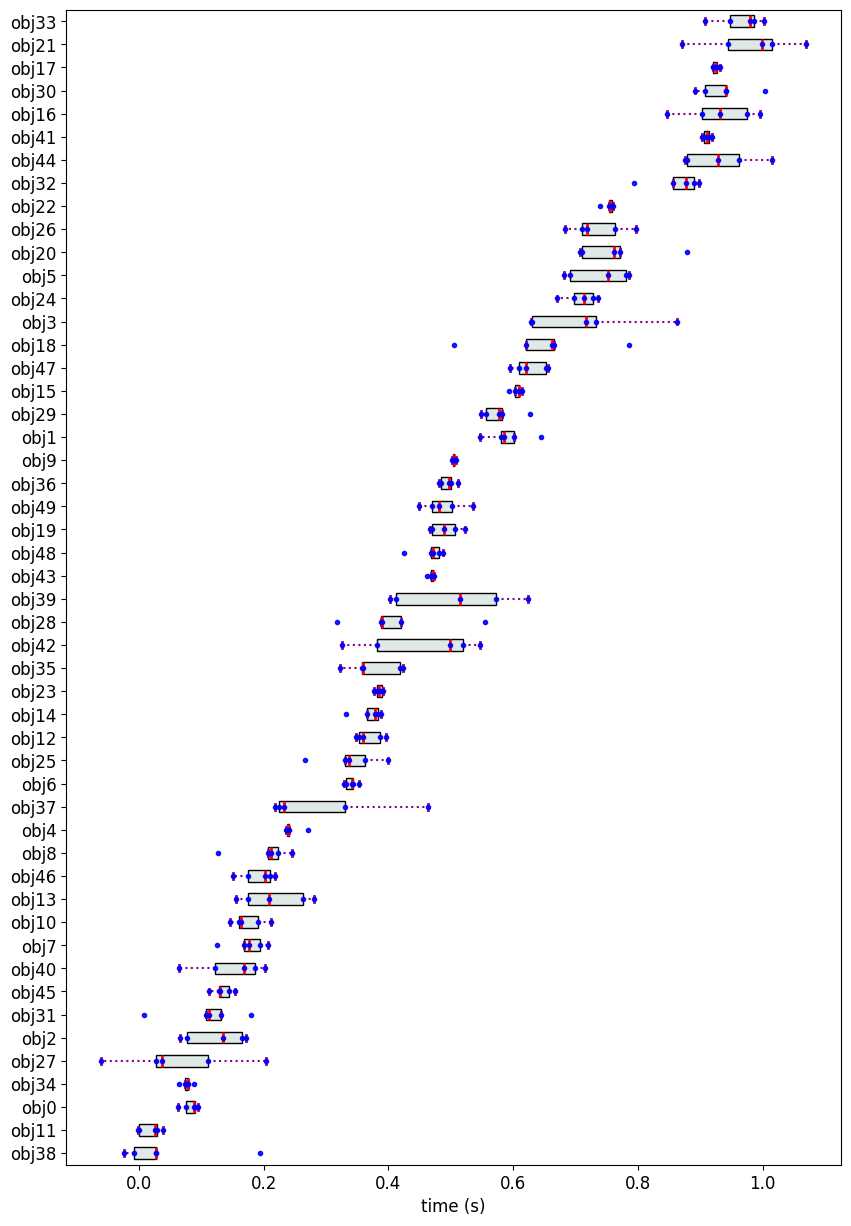

In [115]:
mv = MeasurementsVisualizer(measurements, pr_.get_separable_arrangement())
fig = mv.show_measurements_boxplots(scale=0.3)

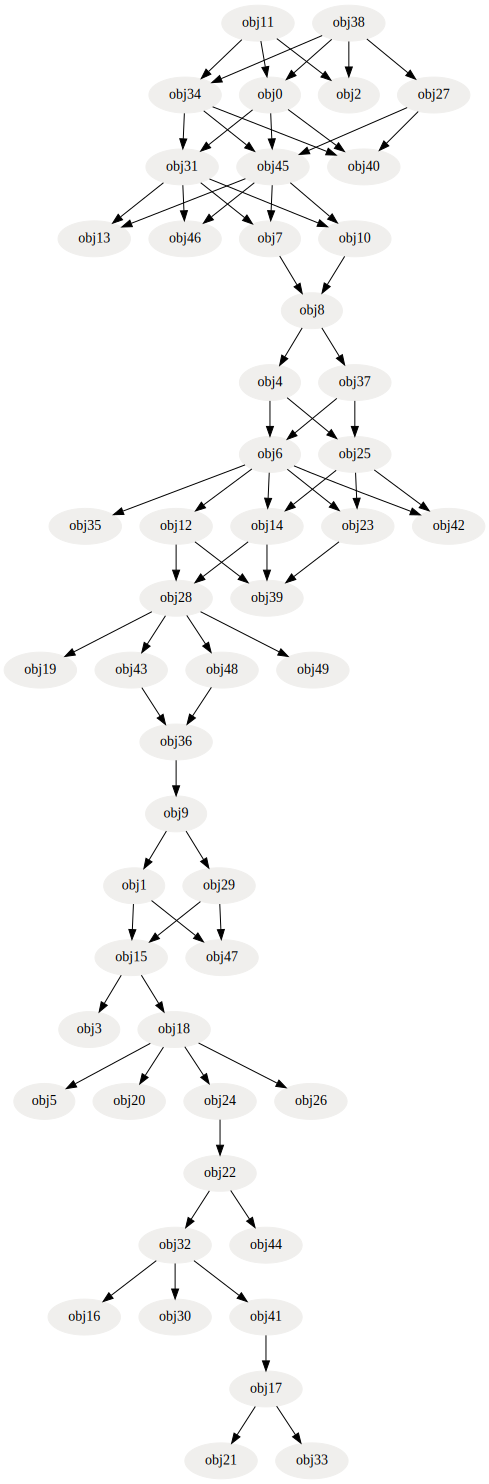

In [116]:
pr_.get_dfg().visualize()

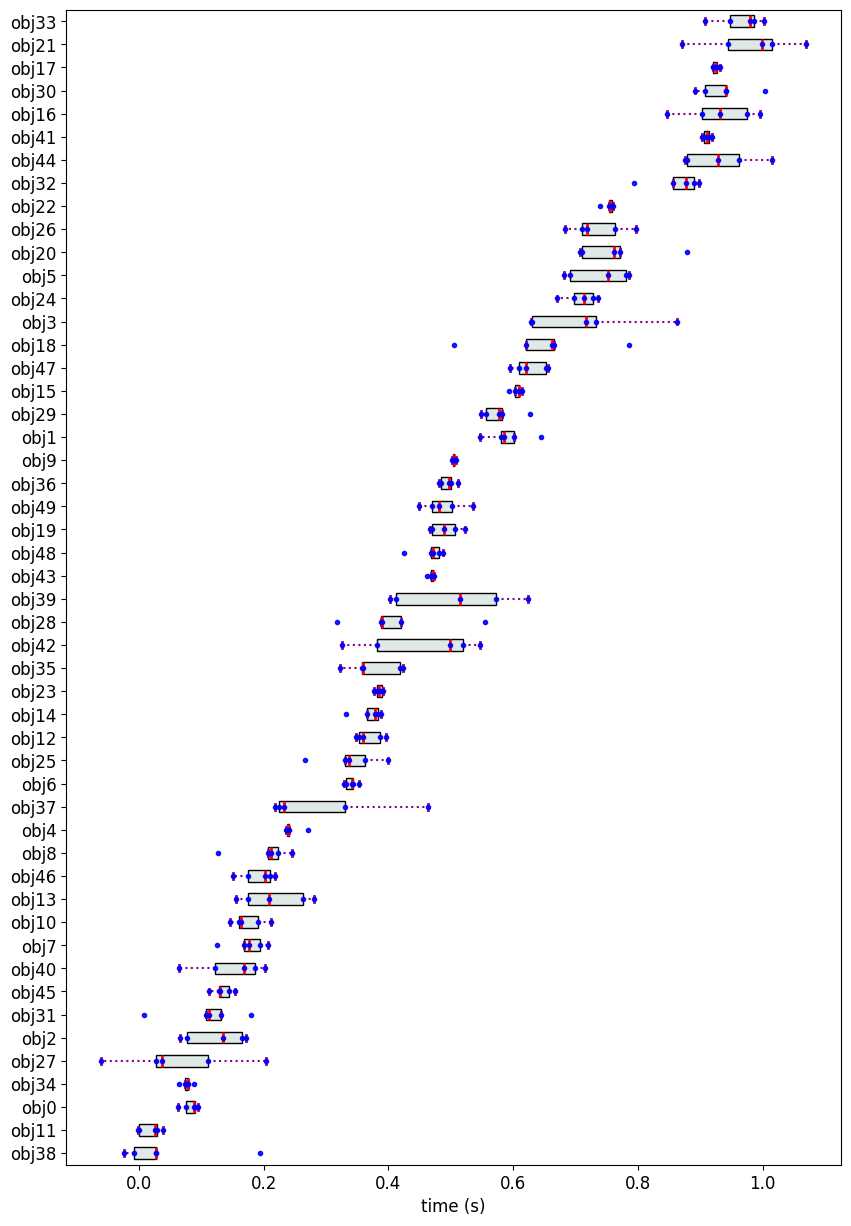

In [117]:
pr_.compute_ranks(Method.DFGReduced)
mv = MeasurementsVisualizer(measurements, pr_.get_separable_arrangement())
fig = mv.show_measurements_boxplots(scale=0.3)

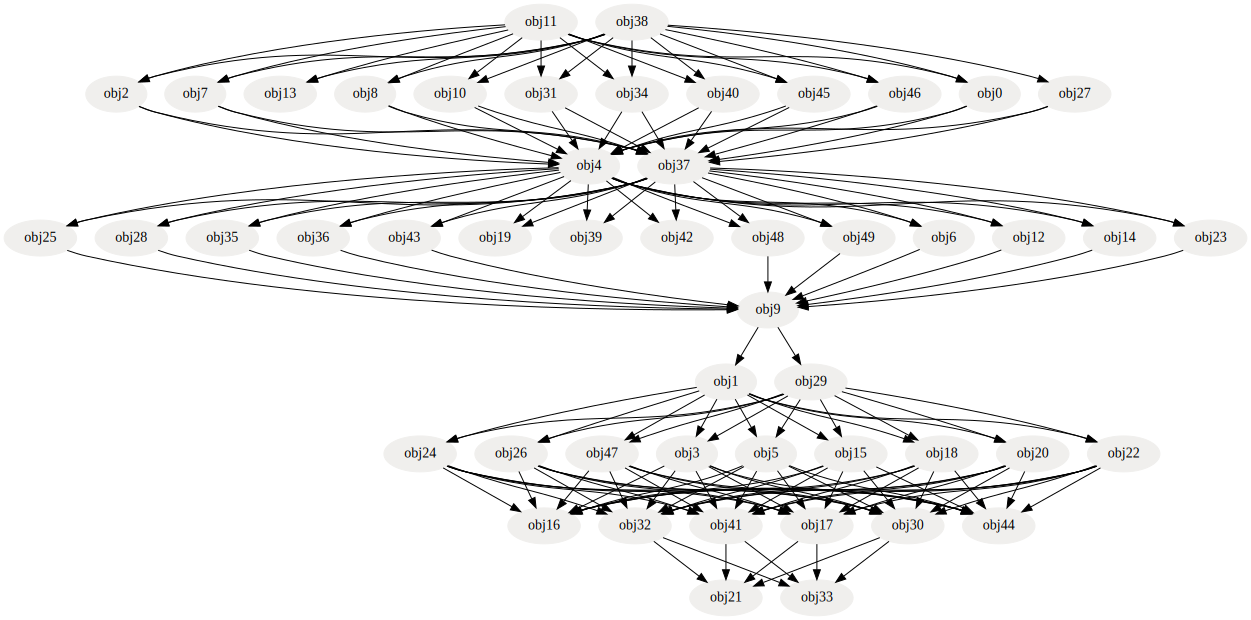

In [118]:
pr_.get_dfg().visualize()

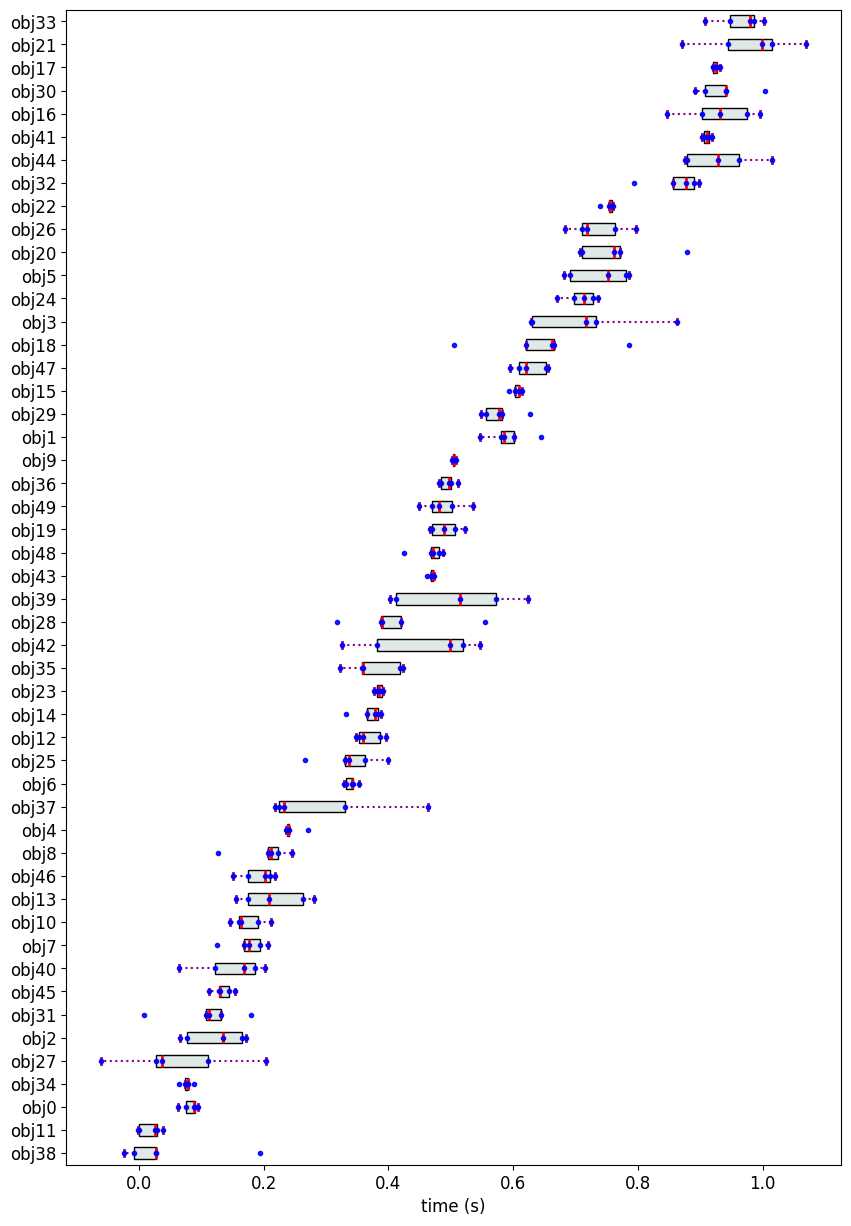

In [119]:
pr_.compute_ranks(Method.Min)
mv = MeasurementsVisualizer(measurements, pr_.get_separable_arrangement())
fig = mv.show_measurements_boxplots(scale=0.3)

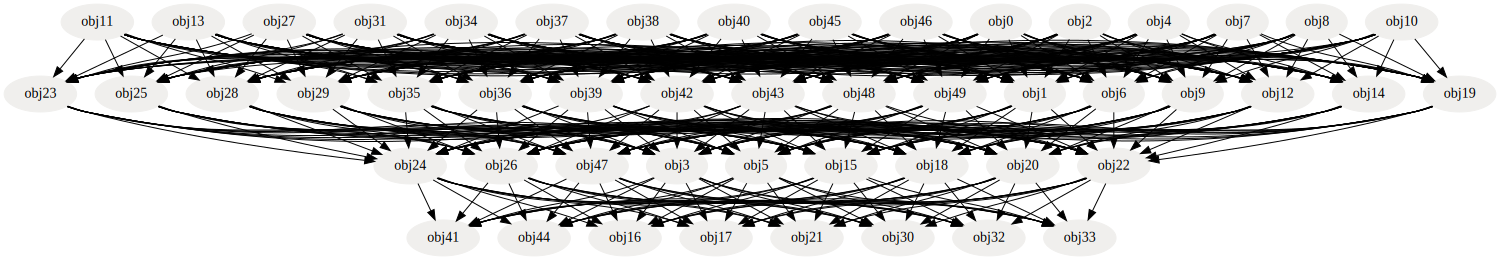

In [120]:
pr_.get_dfg().visualize()